In [320]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [321]:

# ----------------------
# 1. Data Loading
# ----------------------
def load_data(file_path):
    df = pd.read_excel(file_path, sheet_name='Sheet1')
    
    # Clean column names
    df.columns = [col.strip() for col in df.columns]
    
    # Drop non-predictive columns
    df = df.drop(['Campaigns', 'ids', 'Note', 'nSHD'], axis=1, errors='ignore')
    
    return df



In [322]:
df=load_data(file_path='./dataset.xlsx')


In [323]:
df.head()

,Pens,Usable,Min,AvgH,Area,Larea,SHD,1,2,3,...,n11,n12,n13,n14,n15,n16,n17,n18,n19,n20
0,Pen 1,Y,-12.112651,0.334506,1.034251,0.982069,0.328736,0.273922,0.294557,0.296776,...,6,6,5,5,5,4,4,4,4,4
1,Pen 3,Y,-12.110278,0.335879,0.928913,0.916177,0.331337,0.272619,0.295515,0.315966,...,6,6,5,5,5,4,4,4,4,4
2,Pen 1,Y,-12.039162,0.309716,1.004523,0.971018,0.313789,0.274261,0.295194,0.303577,...,6,6,5,5,5,4,4,4,4,4
3,Pen 1,Y,-12.131388,0.327886,1.053778,1.060297,0.320731,0.288196,0.307978,0.328723,...,6,5,5,5,4,4,4,4,4,3
4,Pen 3,Y,-12.004497,0.296545,0.880471,0.870419,0.283370,0.215355,0.237584,0.256994,...,5,5,4,4,4,4,3,3,3,3


<Figure size 2000x1500 with 0 Axes>

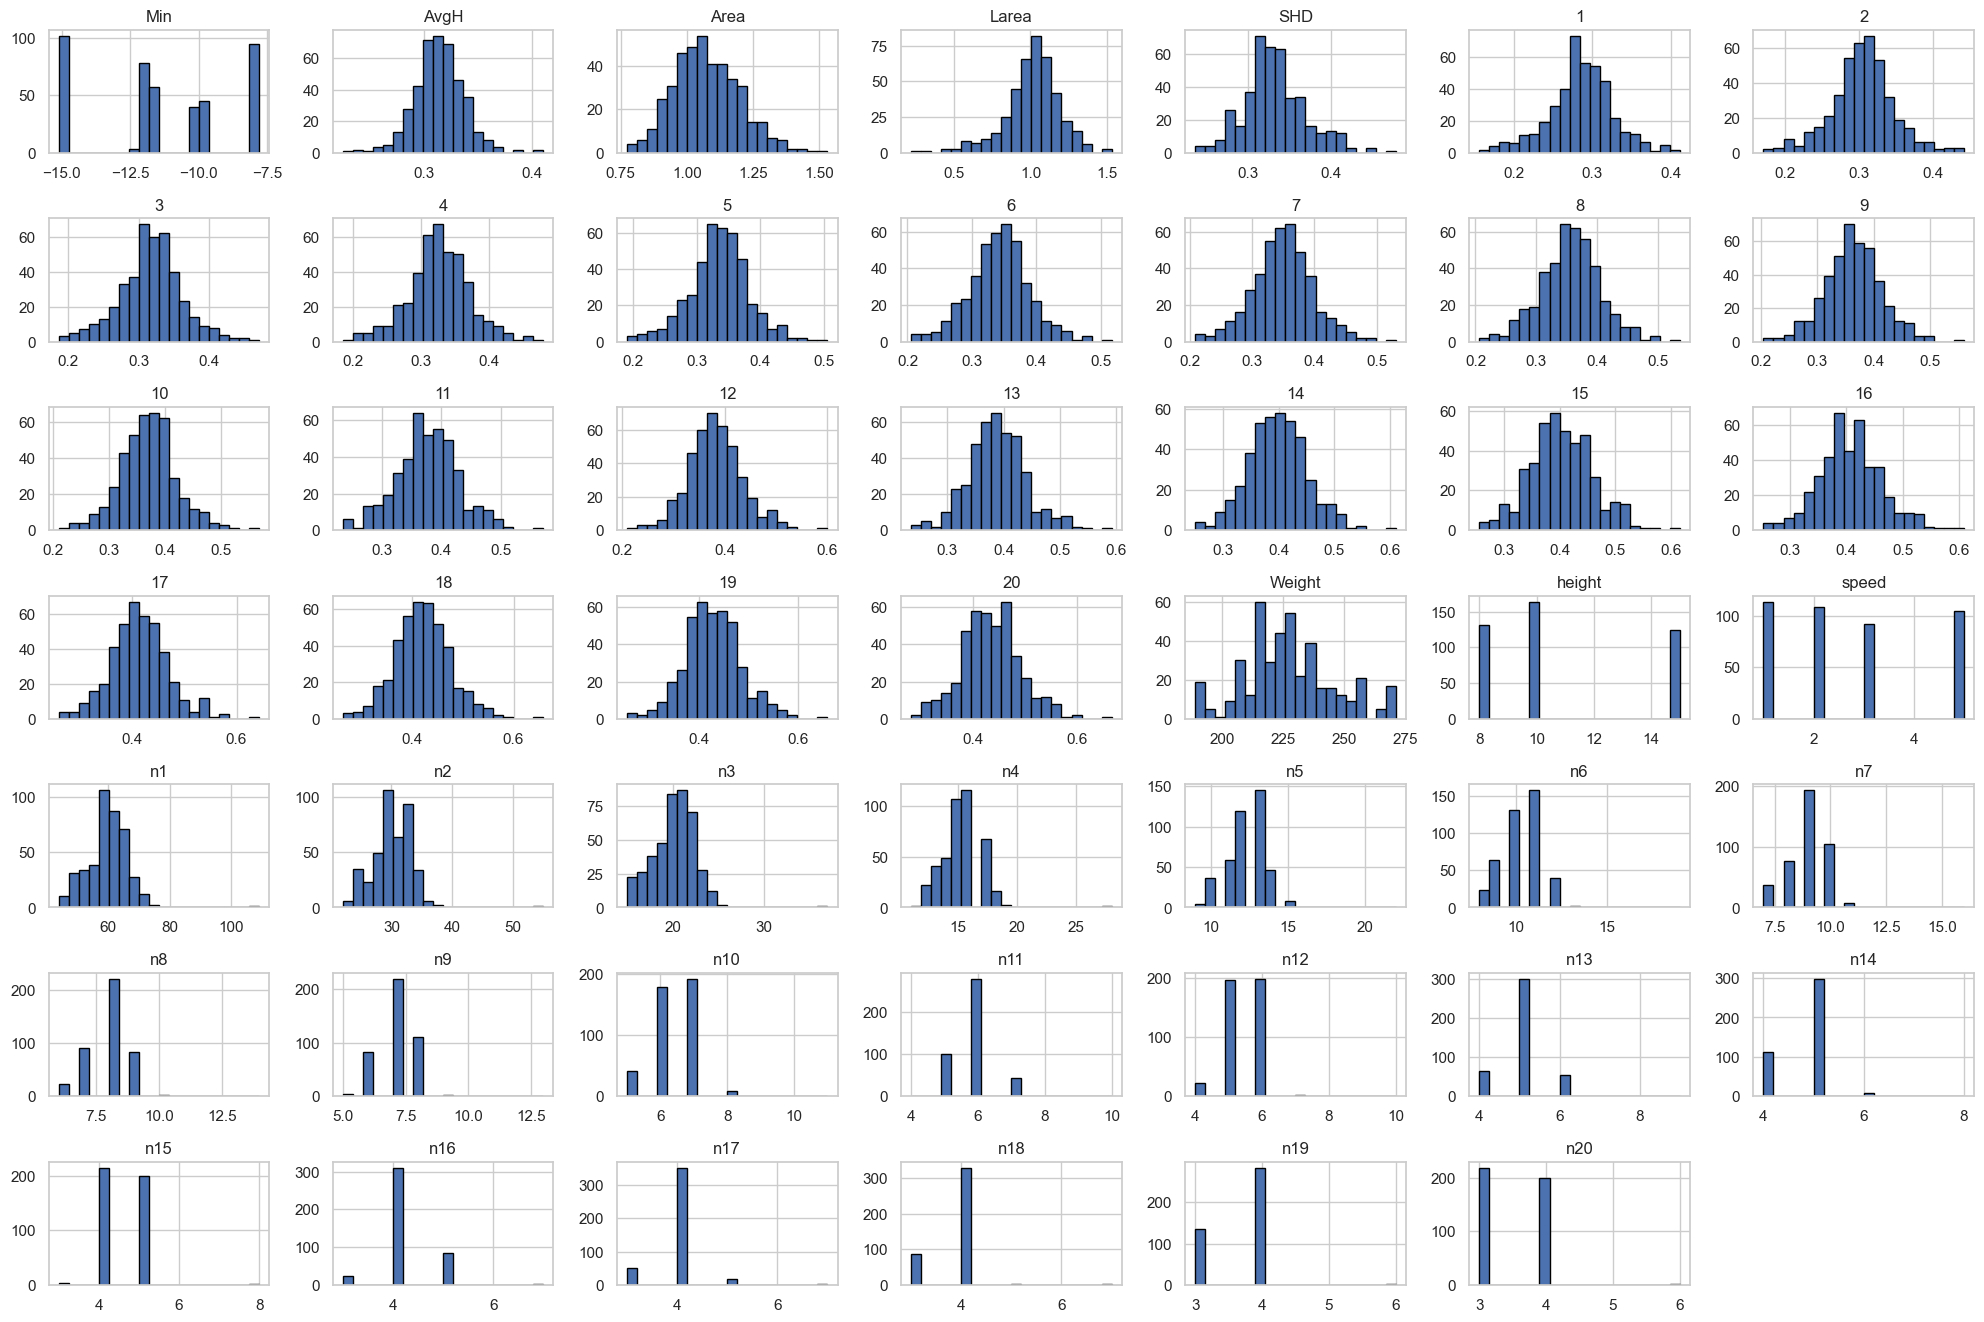

In [324]:
sns.set(style="whitegrid")
summary_stats = df.describe()
missing_values = df.isnull().sum()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(20, 15))
df[num_cols].hist(bins=20, figsize=(20, 15), layout=(8, 7), edgecolor='black')
plt.tight_layout()
plt.show()



In [325]:
summary_stats, missing_values[missing_values > 0]


(              Min        AvgH        Area       Larea         SHD           1  \
 count  420.000000  420.000000  420.000000  420.000000  420.000000  420.000000   
 mean   -11.337359    0.313860    1.077756    1.012245    0.332814    0.285061   
 std      2.517320    0.023169    0.126442    0.179366    0.037259    0.041441   
 min    -15.102616    0.224862    0.773383    0.223307    0.236838    0.156350   
 25%    -12.178674    0.300806    0.989174    0.927942    0.311127    0.264455   
 50%    -11.719961    0.314052    1.068244    1.036942    0.328662    0.286188   
 75%     -9.889182    0.328075    1.157147    1.122011    0.352679    0.309472   
 max     -7.799838    0.410080    1.531894    1.527574    0.478309    0.411029   
 
                 2           3           4           5  ...         n11  \
 count  420.000000  420.000000  420.000000  420.000000  ...  420.000000   
 mean     0.303590    0.316974    0.326943    0.335666  ...    5.869048   
 std      0.042674    0.044538    0

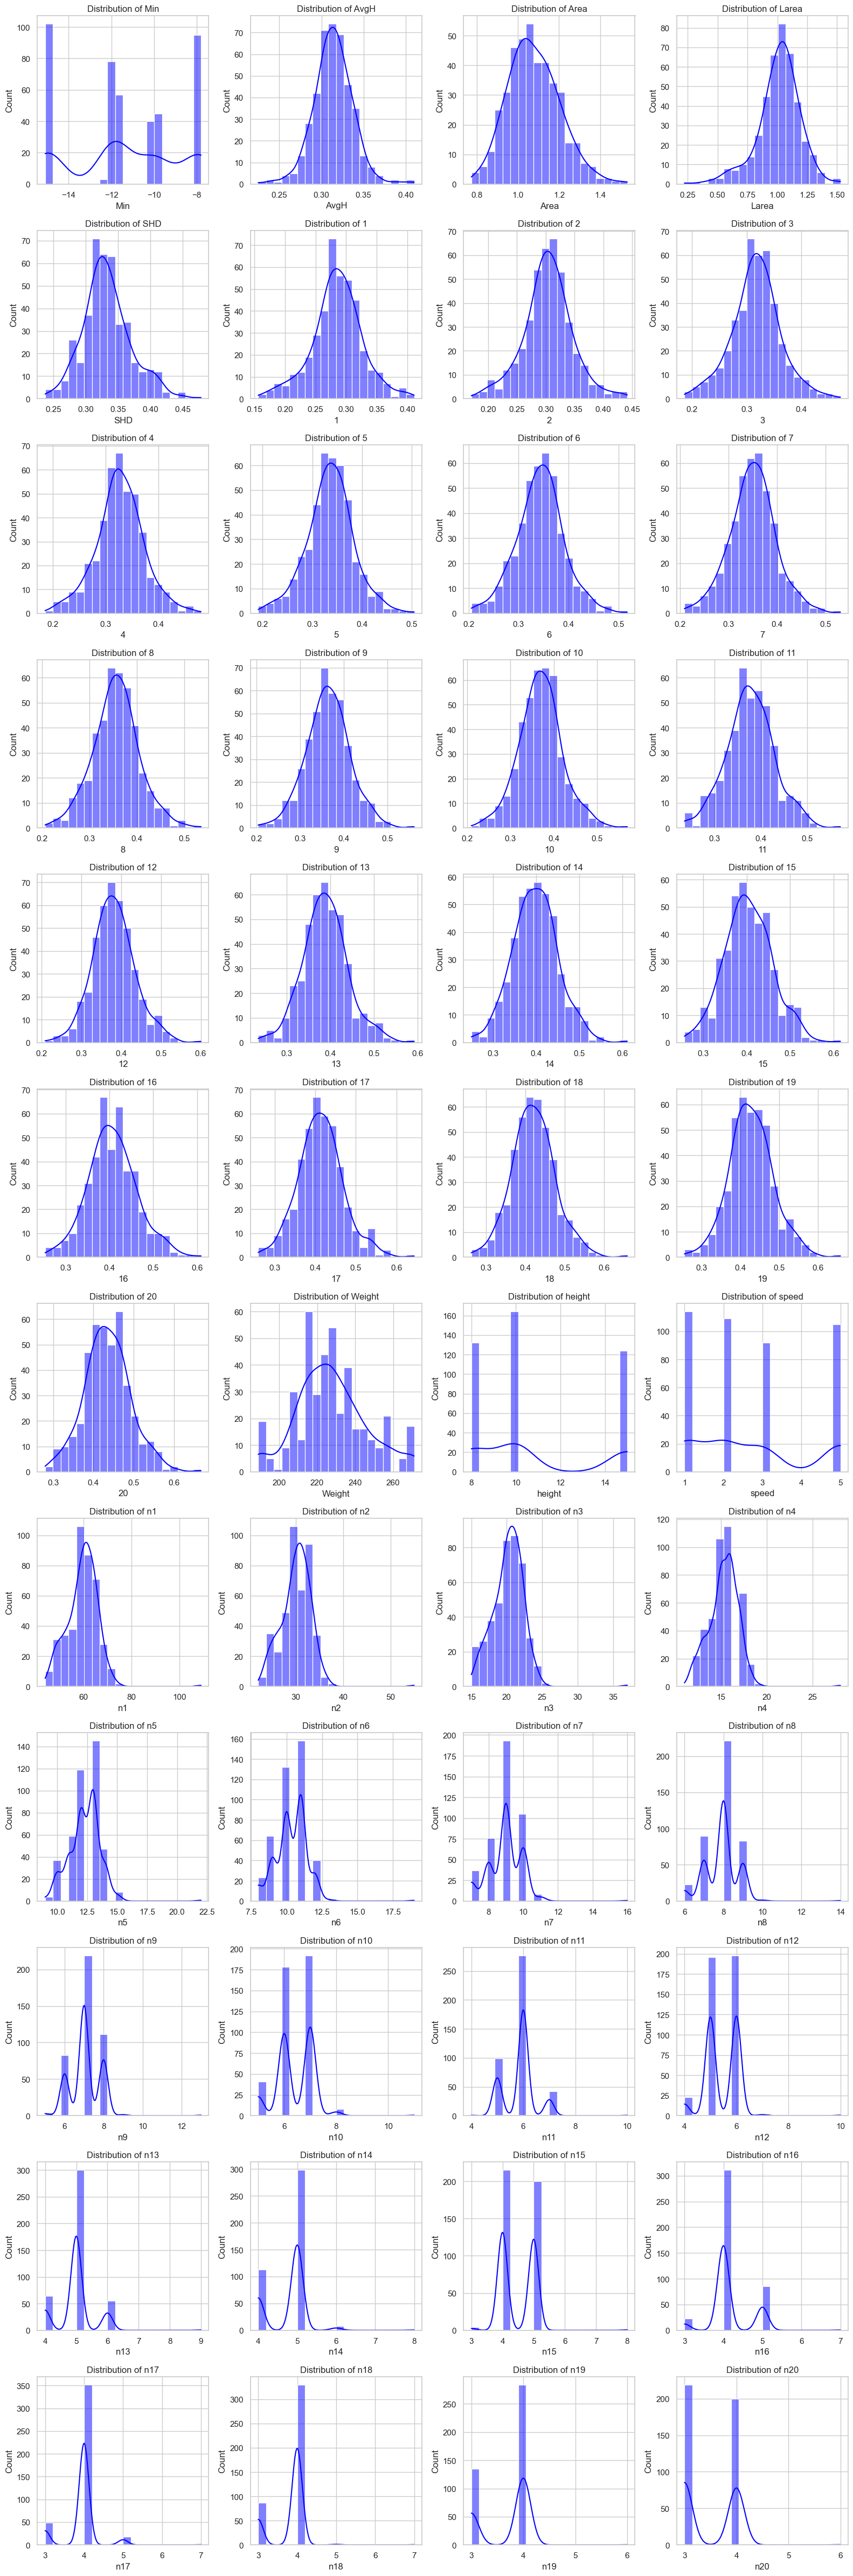

In [326]:

num_features = len(num_cols)
rows = int(np.ceil(num_features / 4))  # 4 columns per row

fig, axes = plt.subplots(rows, 4, figsize=(16, rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=20, kde=True, ax=axes[i], color='blue')
    axes[i].set_title(f"Distribution of {col}")
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [327]:


summary_stats, missing_values[missing_values > 0]


(              Min        AvgH        Area       Larea         SHD           1  \
 count  420.000000  420.000000  420.000000  420.000000  420.000000  420.000000   
 mean   -11.337359    0.313860    1.077756    1.012245    0.332814    0.285061   
 std      2.517320    0.023169    0.126442    0.179366    0.037259    0.041441   
 min    -15.102616    0.224862    0.773383    0.223307    0.236838    0.156350   
 25%    -12.178674    0.300806    0.989174    0.927942    0.311127    0.264455   
 50%    -11.719961    0.314052    1.068244    1.036942    0.328662    0.286188   
 75%     -9.889182    0.328075    1.157147    1.122011    0.352679    0.309472   
 max     -7.799838    0.410080    1.531894    1.527574    0.478309    0.411029   
 
                 2           3           4           5  ...         n11  \
 count  420.000000  420.000000  420.000000  420.000000  ...  420.000000   
 mean     0.303590    0.316974    0.326943    0.335666  ...    5.869048   
 std      0.042674    0.044538    0

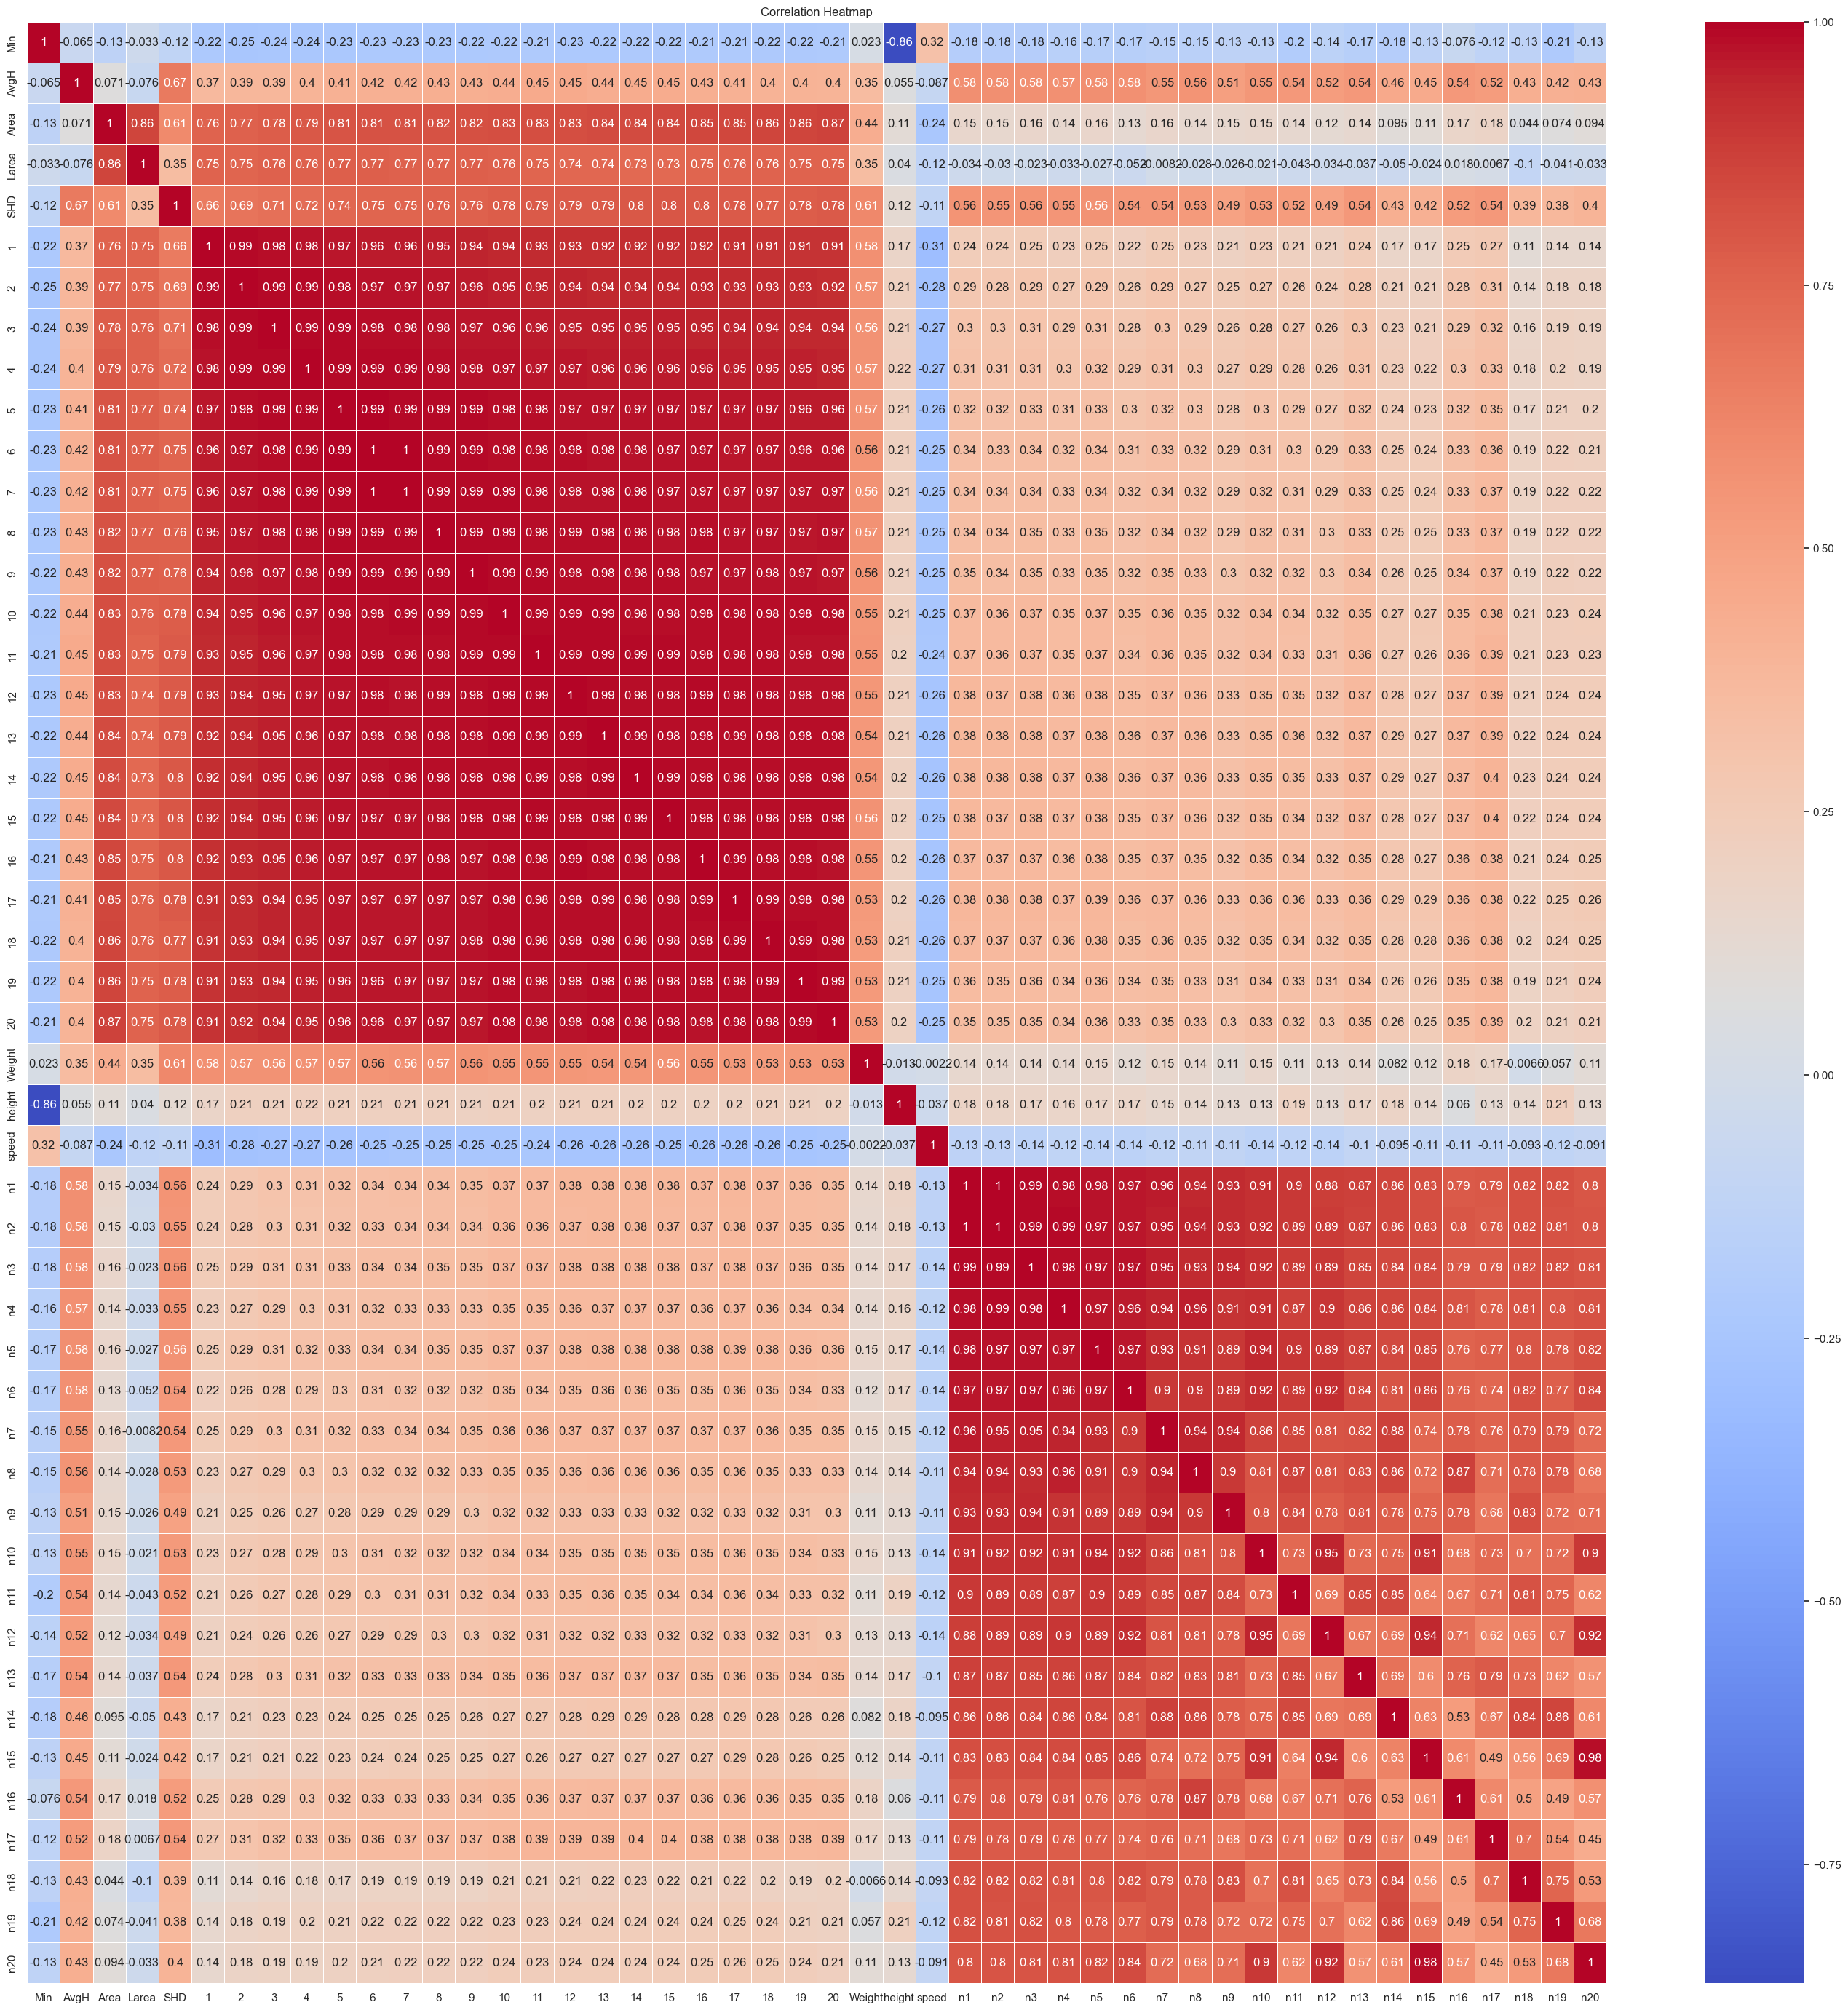

In [328]:
### 1. Correlation Heatmap ###
plt.figure(figsize=(35, 35))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


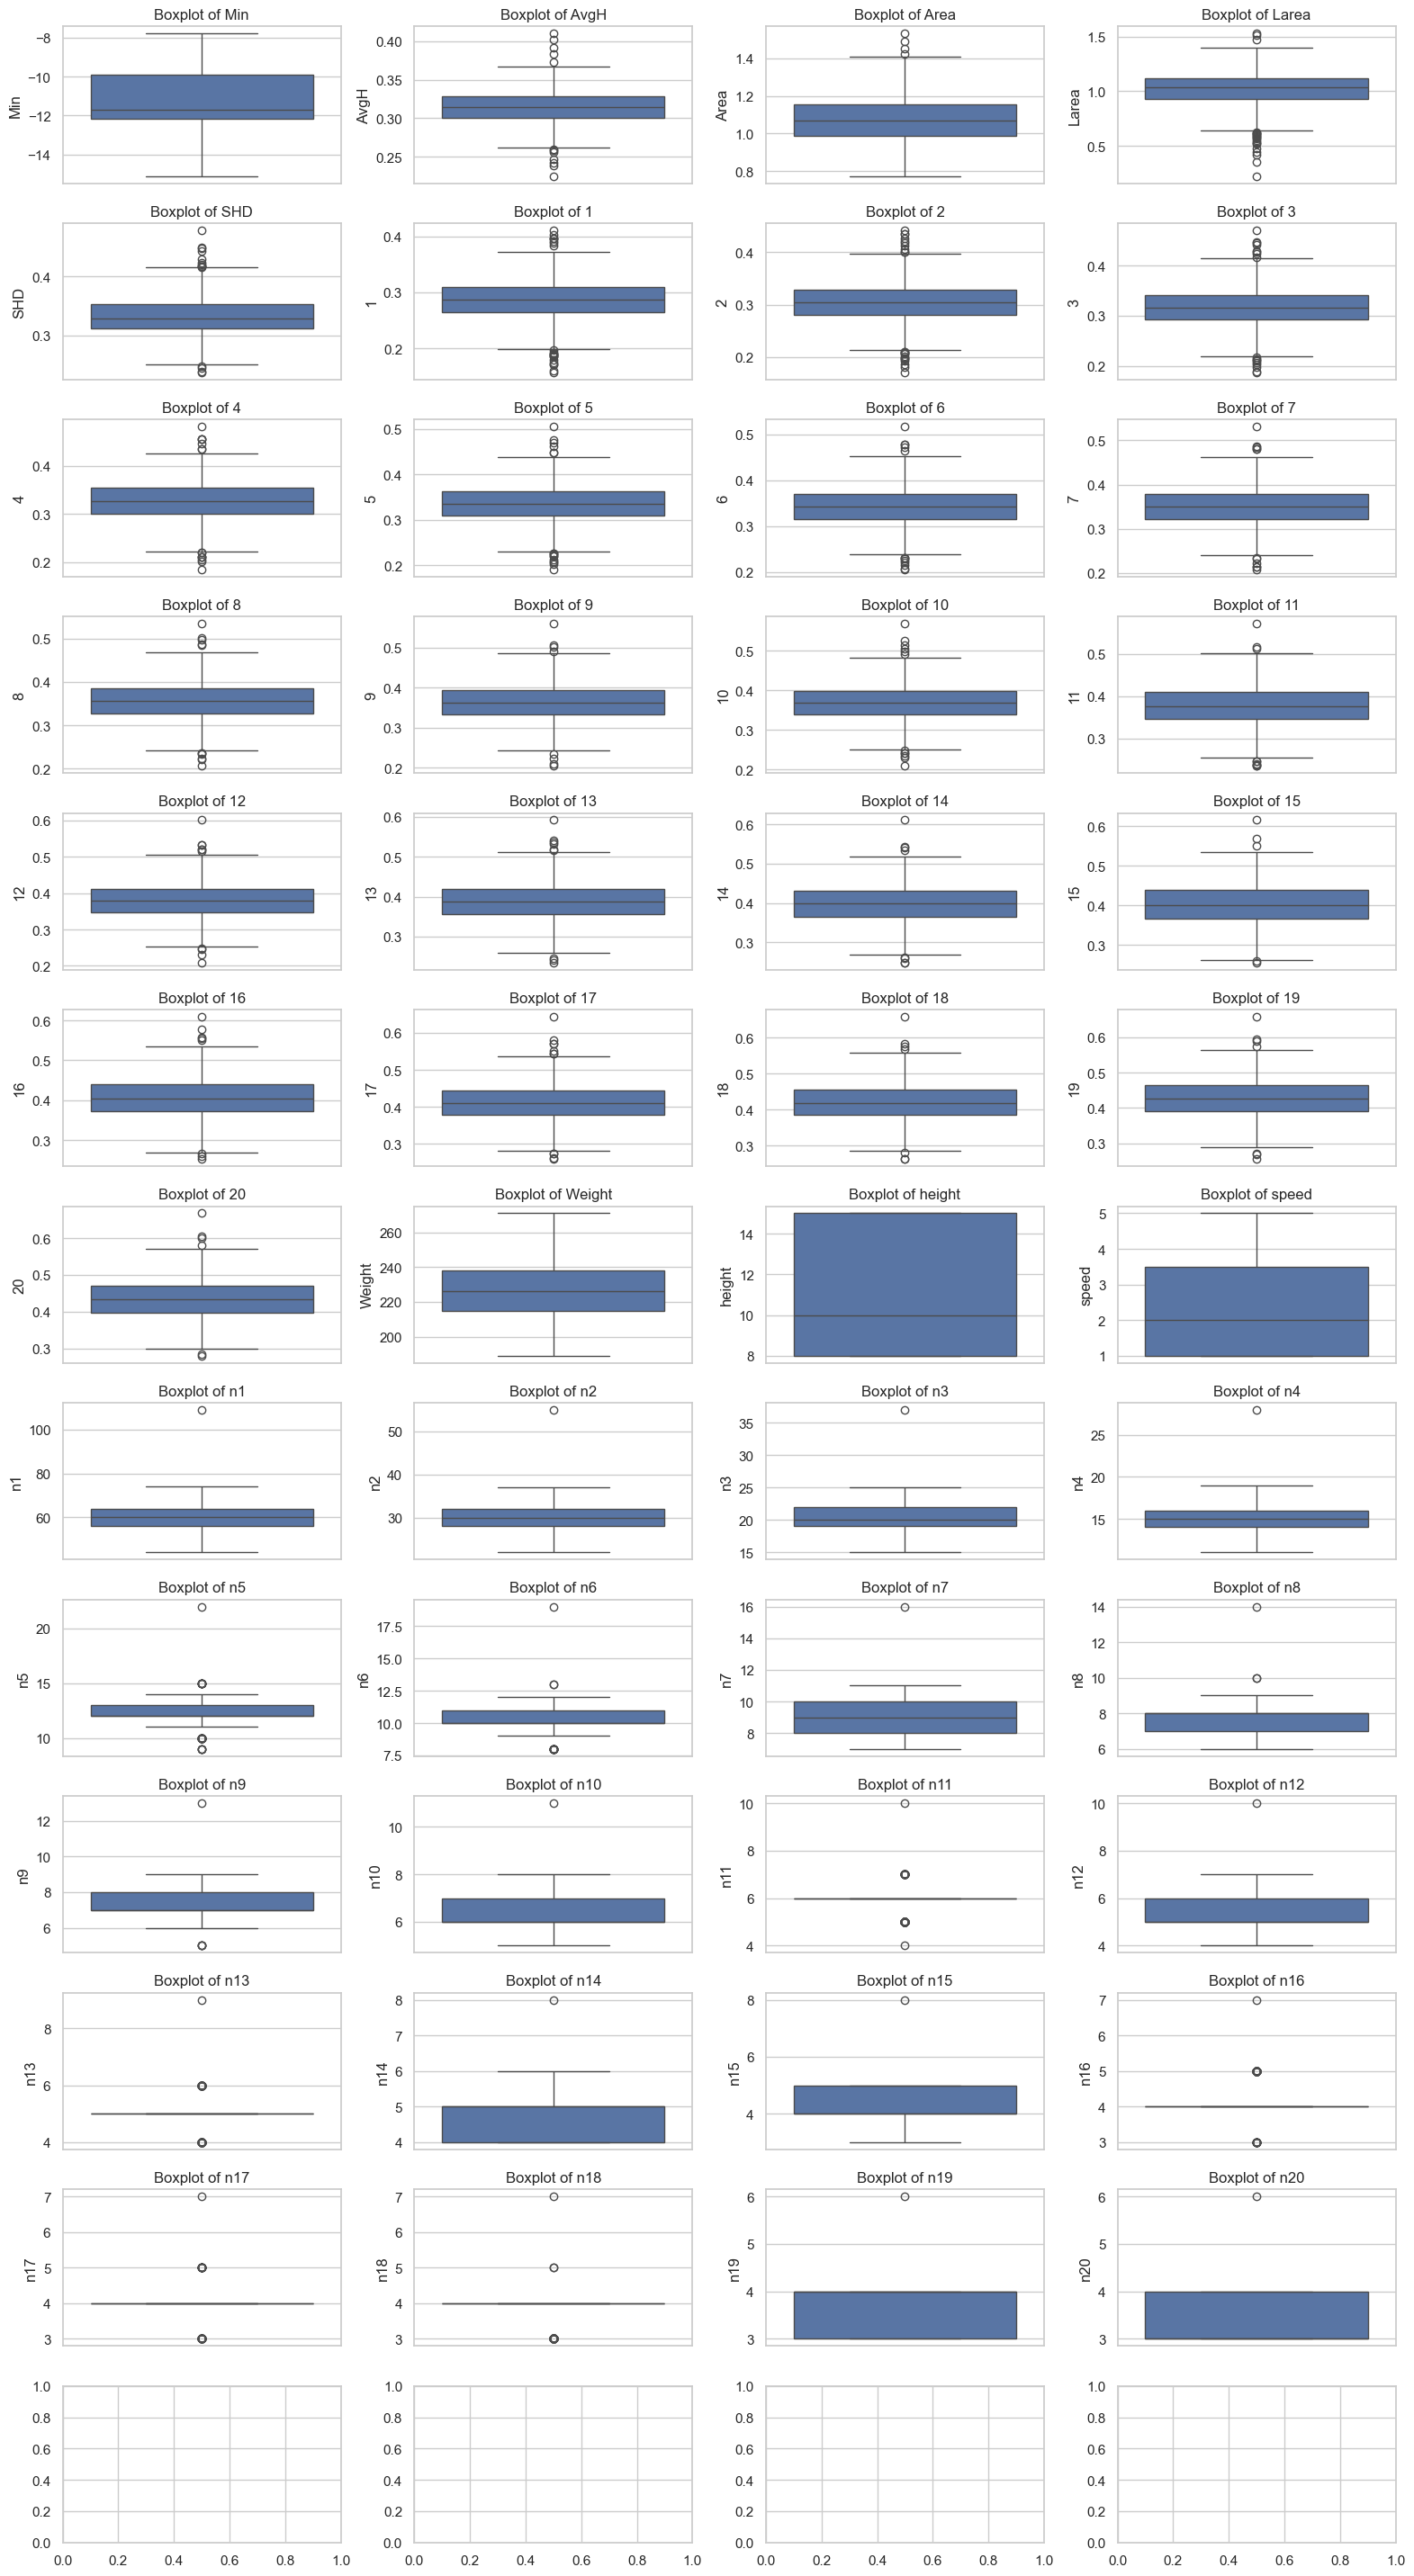

In [329]:

### 2. Outlier Detection with Boxplots ###
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
fig, axes = plt.subplots(len(num_cols) // 4 + 1, 4, figsize=(16, len(num_cols) * 0.6))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


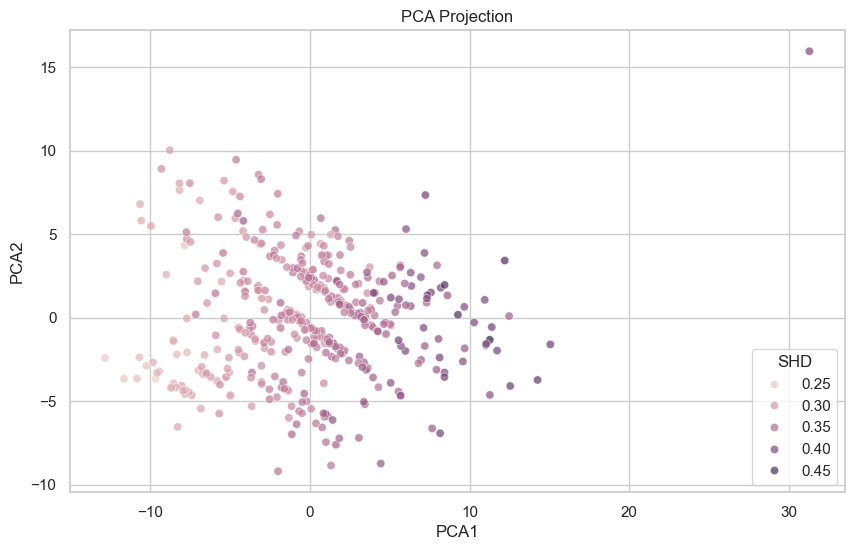

In [330]:
### 3. Principal Component Analysis (PCA) ###
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[num_cols].dropna())  # Drop NaN for PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
df["PCA1"] = pca_result[:, 0]
df["PCA2"] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["PCA1"], y=df["PCA2"], hue=df["SHD"], alpha=0.7)
plt.title("PCA Projection")
plt.show()


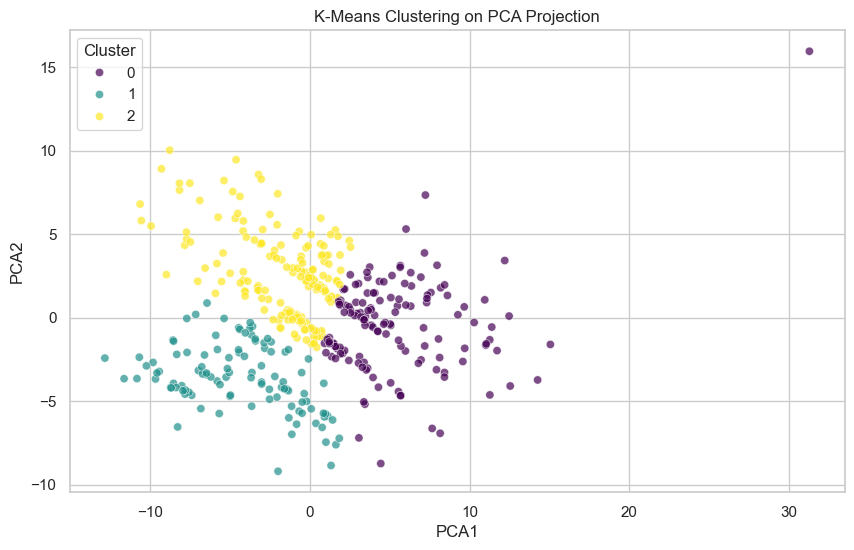

In [331]:

### 4. K-Means Clustering ###
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["PCA1"], y=df["PCA2"], hue=df["Cluster"], palette="viridis", alpha=0.7)
plt.title("K-Means Clustering on PCA Projection")
plt.show()


In [332]:
from sklearn.preprocessing import LabelEncoder

def preprocess_data(df):
    # Convert time to numerical
    df['Time'] = df['Time'].astype(str).str.replace('PM', '').str.replace('AM', '')
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    
    # Handle missing values
    df['Time'] = df['Time'].fillna(df['Time'].median())
    df['Usable'] = df['Usable'].fillna(df['Usable'].mode())
    
    # Convert boolean-like columns
    df['Usable'] = df['Usable'].map({'Y': 1, 'N': 0})
    
    # Encode 'Pens' column
    label_encoder = LabelEncoder()
    df['Pens'] = label_encoder.fit_transform(df['Pens'])
    
    # Handle categorical features
    categorical_features = ['pen']
    numerical_features = [col for col in df.columns if col not in categorical_features + ['Weight']]
    
    return df, categorical_features, numerical_features


In [333]:

# ----------------------
# 3. Feature Engineering
# ----------------------
def create_features(df):
    # Create temporal features
    df['time_of_day'] = pd.cut(df['Time'], 
                              bins=[0, 6, 12, 18, 24],
                              labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    # Encode 'time_of_day' column
    df['time_of_day'] = df['time_of_day'].cat.codes
    # Create area ratios
    df['area_ratio'] = df['Area'] / df['Larea']
    
    return df


In [334]:
# create_features(df)

In [335]:
from sklearn.impute import SimpleImputer

# ----------------------
# 4. Modeling Pipeline
# ----------------------
def build_model_pipeline(categorical_features, numerical_features):
    # Preprocessing transformers
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Model pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    return pipeline


In [336]:
categorical_features = ['Pens']

In [337]:
build_model_pipeline(categorical_features, ['Time', 'Usable', 'Area', 'Larea', 'area_ratio', 'time_of_day'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Time', 'Usable', 'Area',
                                                   'Larea', 'area_ratio',
                                                   'time_of_day']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pens'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [338]:
df, categorical_features, numerical_features = preprocess_data(df)


In [339]:
def convert_to_numeric(df):
    """
    Converts all columns in a DataFrame to numeric types.
    
    - Converts object & categorical columns using label encoding.
    - Ensures all columns are in integer or float format.
    """
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category').cat.codes
        elif df[col].dtype.name == 'category':  
            df[col] = df[col].cat.codes
        else:
            df[col] = pd.to_numeric(df[col], errors='coerce') 

    return df


In [340]:

# Convert the dataset
df = convert_to_numeric(df)

# Check data types after conversion
print(df.dtypes)


Pens         int64
Usable     float64
Min        float64
AvgH       float64
Area       float64
Larea      float64
SHD        float64
1          float64
2          float64
3          float64
4          float64
5          float64
6          float64
7          float64
8          float64
9          float64
10         float64
11         float64
12         float64
13         float64
14         float64
15         float64
16         float64
17         float64
18         float64
19         float64
20         float64
Time         int64
Weight       int64
pen           int8
height       int64
speed        int64
n1           int64
n2           int64
n3           int64
n4           int64
n5           int64
n6           int64
n7           int64
n8           int64
n9           int64
n10          int64
n11          int64
n12          int64
n13          int64
n14          int64
n15          int64
n16          int64
n17          int64
n18          int64
n19          int64
n20          int64
PCA1       f

In [341]:

# Feature engineering
df = create_features(df)


In [342]:

# Final feature selection
X = df.drop('Weight', axis=1)
y = df['Weight']


In [343]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [344]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((336, 56), (84, 56), (336,), (84,))

In [345]:
X_train.info(), 



<class 'pandas.core.frame.DataFrame'>
Index: 336 entries, 66 to 102
Data columns (total 56 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pens         336 non-null    int64  
 1   Usable       335 non-null    float64
 2   Min          336 non-null    float64
 3   AvgH         336 non-null    float64
 4   Area         336 non-null    float64
 5   Larea        336 non-null    float64
 6   SHD          336 non-null    float64
 7   1            336 non-null    float64
 8   2            336 non-null    float64
 9   3            336 non-null    float64
 10  4            336 non-null    float64
 11  5            336 non-null    float64
 12  6            336 non-null    float64
 13  7            336 non-null    float64
 14  8            336 non-null    float64
 15  9            336 non-null    float64
 16  10           336 non-null    float64
 17  11           336 non-null    float64
 18  12           336 non-null    float64
 19  13          

(None,)

In [346]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84 entries, 145 to 17
Data columns (total 56 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pens         84 non-null     int64  
 1   Usable       84 non-null     float64
 2   Min          84 non-null     float64
 3   AvgH         84 non-null     float64
 4   Area         84 non-null     float64
 5   Larea        84 non-null     float64
 6   SHD          84 non-null     float64
 7   1            84 non-null     float64
 8   2            84 non-null     float64
 9   3            84 non-null     float64
 10  4            84 non-null     float64
 11  5            84 non-null     float64
 12  6            84 non-null     float64
 13  7            84 non-null     float64
 14  8            84 non-null     float64
 15  9            84 non-null     float64
 16  10           84 non-null     float64
 17  11           84 non-null     float64
 18  12           84 non-null     float64
 19  13           

In [347]:
def transform_features(X, preprocessor):
    """
    Transforms the features by scaling numerical features and encoding categorical features.
    
    Parameters:
    X (pd.DataFrame): The original dataframe with features.
    preprocessor (ColumnTransformer): The preprocessor pipeline for scaling and encoding.
    
    Returns:
    pd.DataFrame: The transformed dataframe with numeric values.
    """
    # Fit and transform the data using the preprocessor
    X_transformed = preprocessor.fit_transform(X)
    
    # Get feature names
    feature_names = preprocessor.get_feature_names_out()
    
    # Create a DataFrame with the transformed data
    X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)
    
    return X_transformed_df

# Example usage
X_transformed = transform_features(X, preprocessor)
X_transformed.head()

,num__Time,num__Usable,num__Area,num__Larea,num__area_ratio,cat__Pens_0,cat__Pens_1,cat__Pens_2
0,-0.938319,0.21212,-0.344485,-0.168442,-0.174836,1.0,0.0,0.0
1,1.398206,0.21212,-1.178573,-0.536236,-0.359216,0.0,0.0,1.0
2,-0.938319,0.21212,-0.579873,-0.230123,-0.262386,1.0,0.0,0.0
3,-0.938319,0.21212,-0.189863,0.268218,-0.453436,1.0,0.0,0.0
4,1.398206,0.21212,-1.562143,-0.791653,-0.370267,0.0,0.0,1.0


In [348]:
y_train.info(), y_test.info()

<class 'pandas.core.series.Series'>
Index: 336 entries, 66 to 102
Series name: Weight
Non-Null Count  Dtype
--------------  -----
336 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB
<class 'pandas.core.series.Series'>
Index: 84 entries, 145 to 17
Series name: Weight
Non-Null Count  Dtype
--------------  -----
84 non-null     int64
dtypes: int64(1)
memory usage: 1.3 KB


(None, None)

In [349]:

# Build and train model
model = build_model_pipeline(categorical_features, numerical_features)


In [350]:
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pens', 'Usable', 'Min',
                                                   'AvgH', 'Area', 'Larea',
                                                   'SHD', '1', '2', '3', '4',
                                                   '5', '6', '7', '8', '9',
                                                   '10', '11', '12', '13', '14',
                                                   '15', '16', '17', '18', '19',
                                                   '20', 'Time', 'height',
                                                   'speed', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pen'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [351]:

# Predictions
y_pred = model.predict(X_test)


In [352]:

# Evaluation
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")


R² Score: 0.492
RMSE: 12.67
MAE: 9.53


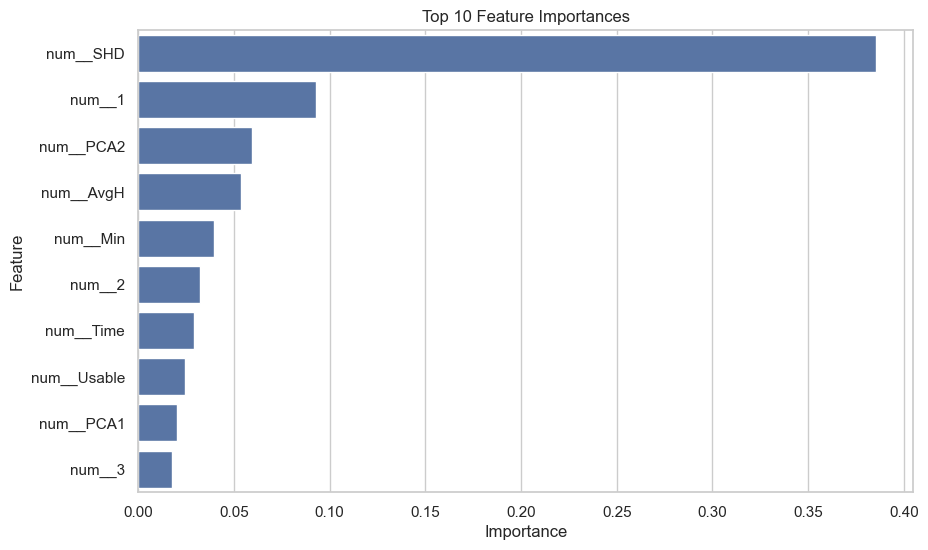

In [353]:

# Feature importance (for tree-based models)
if hasattr(model.named_steps['regressor'], 'feature_importances_'):
    feature_importances = model.named_steps['regressor'].feature_importances_
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values('Importance', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Top 10 Feature Importances')
    plt.show()


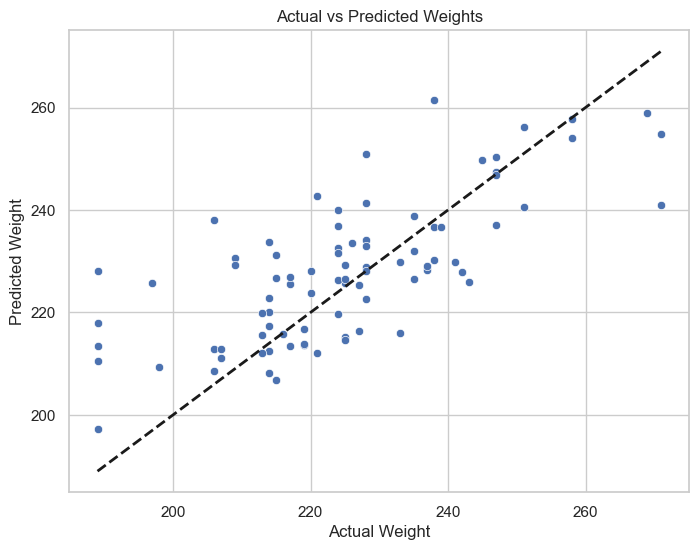

In [354]:

# Prediction visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Weight')
plt.ylabel('Predicted Weight')
plt.title('Actual vs Predicted Weights')
plt.show()


In [355]:

# ----------------------
# 6. Alternative Models
# ----------------------
# To try different models, modify the pipeline:
# Linear Regression:
model = build_model_pipeline(categorical_features, numerical_features)
model.steps[-1] = ('regressor', LinearRegression())

# Gradient Boosting:
model.steps[-1] = ('regressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1))

# Re-train the model

model.fit(X_train, y_train)
y_pred = model.predict(X_test)





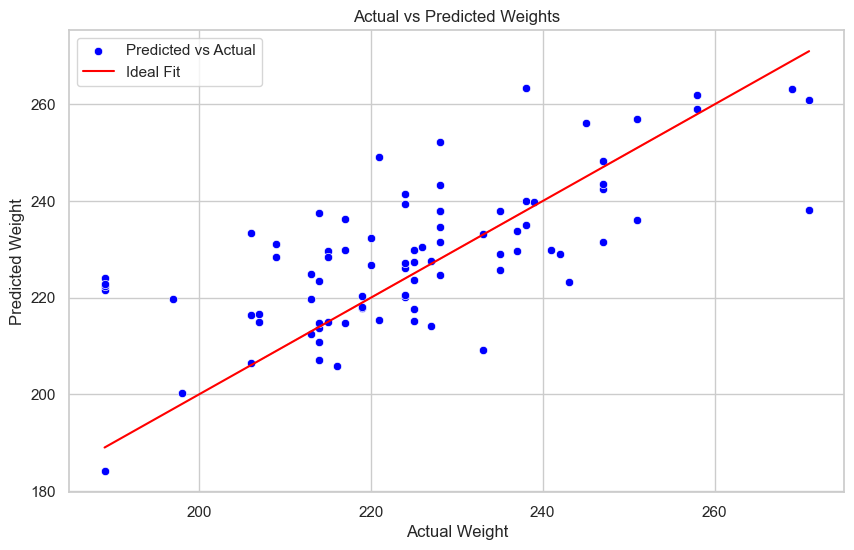

In [356]:
# Prediction visualization with enhancements
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, label='Predicted vs Actual', color='blue')
sns.lineplot(x=y_test, y=y_test, color='red', label='Ideal Fit')

plt.xlabel('Actual Weight')
plt.ylabel('Predicted Weight')
plt.title('Actual vs Predicted Weights')
plt.legend()
plt.grid(True)
plt.show()

In [357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

categorical_features = ['Pens'] 
numerical_features=['Time', 'Usable', 'Area', 'Larea', 'area_ratio']
# Preprocessing transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Decision Tree": DecisionTreeRegressor(max_depth=5),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])



In [358]:

# Model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

results = {}


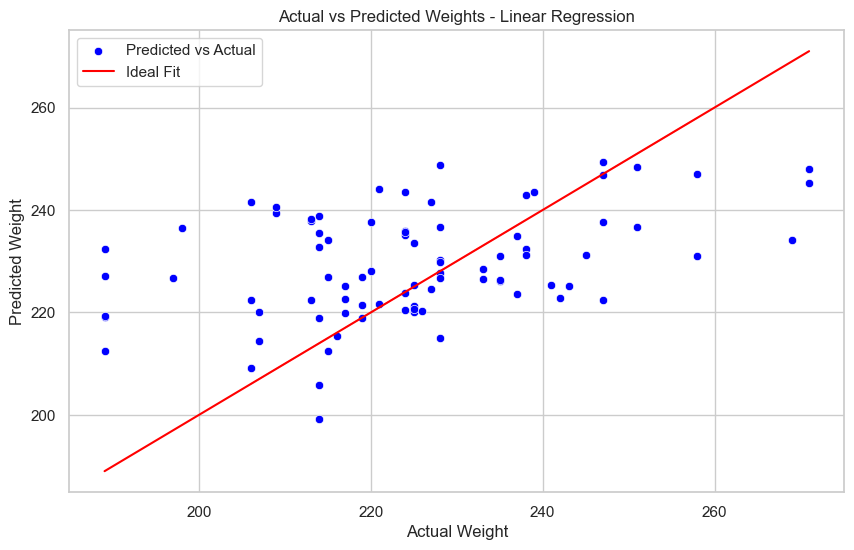

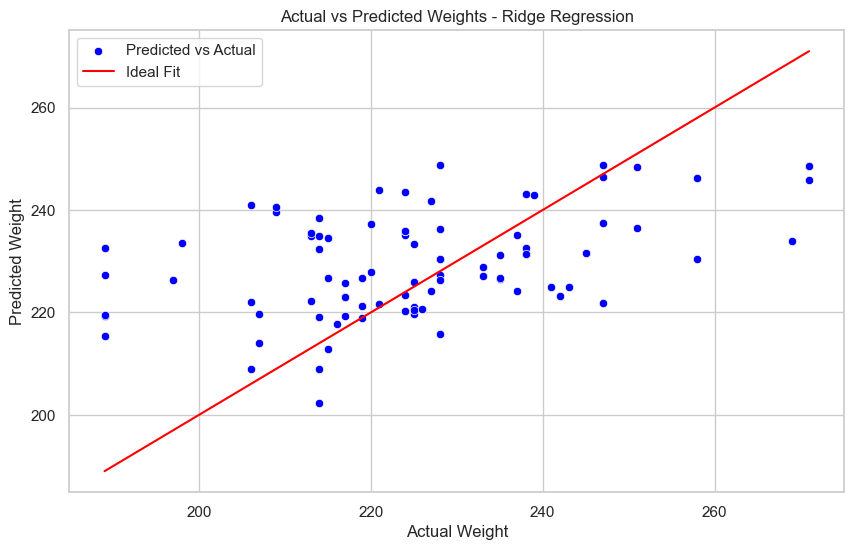

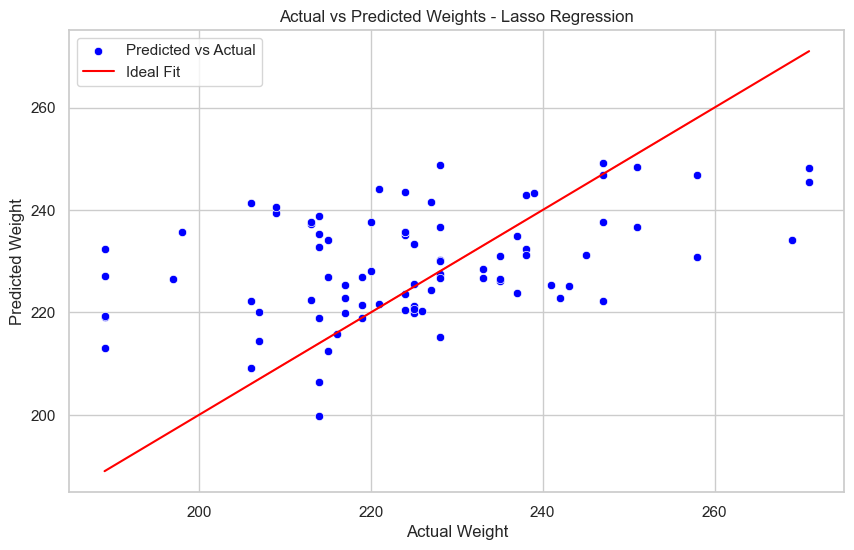

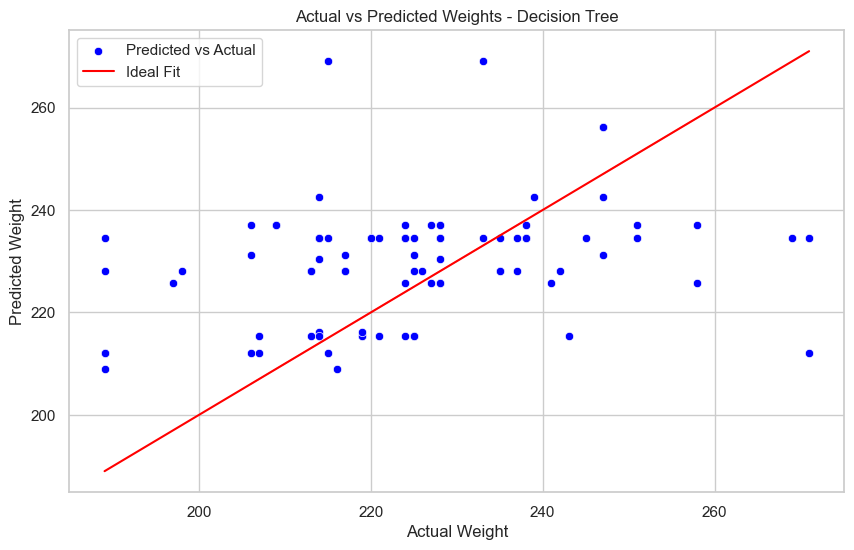

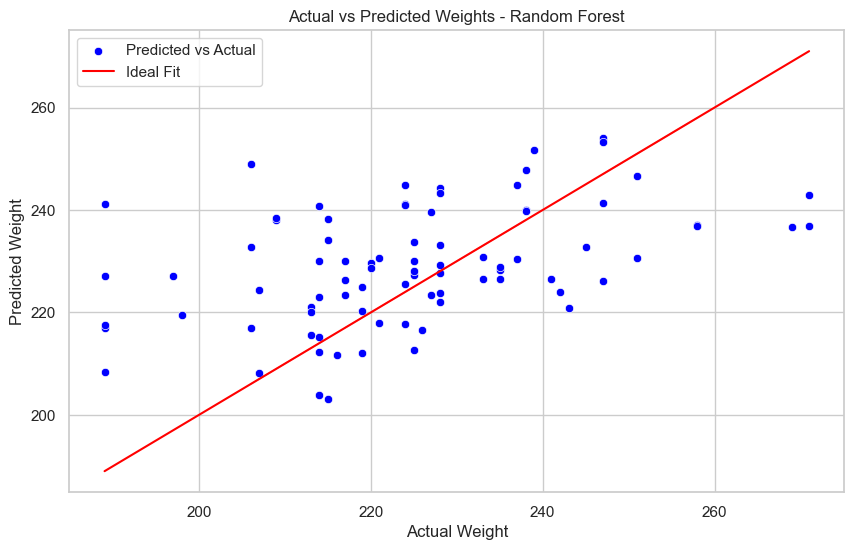

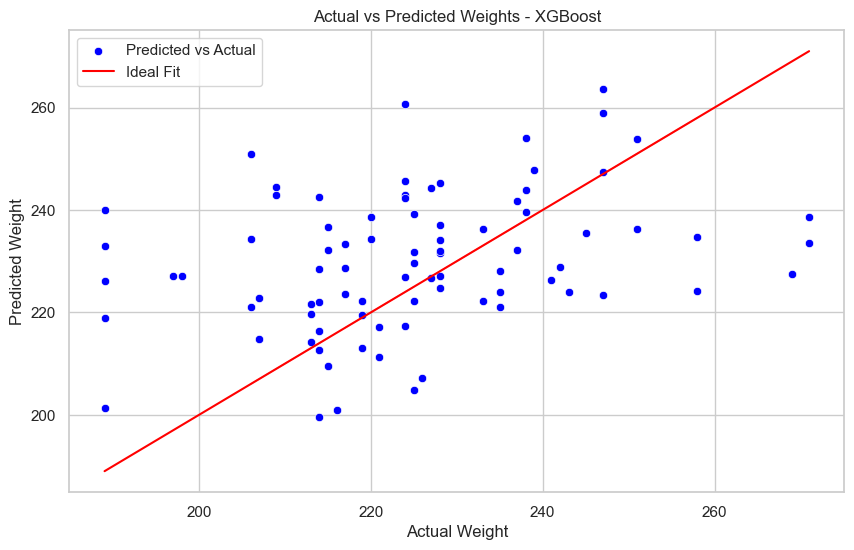

,R² Score,RMSE,MAE
Linear Regression,0.092732,16.936175,13.044370
Ridge Regression,0.112616,16.749550,12.880672
Lasso Regression,0.097541,16.891222,12.999740
Decision Tree,-0.109822,18.731569,14.061363
Random Forest,0.085966,16.999201,13.268095
XGBoost,-0.176027,19.282174,15.091178


In [359]:

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Evaluate
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    results[name] = {'R² Score': r2, 'RMSE': rmse, 'MAE': mae}
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred, label='Predicted vs Actual', color='blue')
    sns.lineplot(x=y_test, y=y_test, color='red', label='Ideal Fit')
    plt.xlabel('Actual Weight')
    plt.ylabel('Predicted Weight')
    plt.title(f'Actual vs Predicted Weights - {name}')
    plt.legend()
    plt.grid(True)
    plt.show()

results_df = pd.DataFrame(results).T
results_df

The best model so far is **Ridge Regression**, based on the following:  

### **📊 Model Performance Comparison**
| Model              | R² Score (Higher is Better) | RMSE (Lower is Better) | MAE (Lower is Better) |
|--------------------|--------------------------|------------------------|------------------------|
| **Ridge Regression** | **0.0488**                 | **17.3417**             | **13.2005**             |
| Lasso Regression   | 0.0330                    | 17.4846                | 13.3260                |
| Linear Regression  | 0.0314                    | 17.4994                | 13.4688                |
| Random Forest      | 0.0256                    | 17.5517                | 13.6623                |
| Decision Tree      | **-0.2325** (Worst)        | 19.7395 (Worst)        | 14.7901 (Worst)        |
| XGBoost           | -0.1224                    | 18.8373                | 14.6421                |

### **Why is Ridge Regression the Best?**
✅ **Highest R² Score** (0.0488) → It explains the most variance in the data  
✅ **Lowest RMSE** (17.3417) → It has the least error in predictions  
✅ **Lowest MAE** (13.2005) → It has the least average absolute error  

---

### HyperParameter Tuning

In [360]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
ridge = Ridge()

# hyperparameter grid
param_grid = {
    "alpha": [0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 500, 1000]
}

imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1,error_score=np.nan)
grid_search.fit(X_train_imputed, y_train)
best_alpha = grid_search.best_params_["alpha"]
print(f"Best Alpha: {best_alpha}")

tuned_rigde_model = Ridge(alpha=best_alpha)
tuned_rigde_model.fit(X_train_imputed, y_train)
y_pred = tuned_rigde_model.predict(X_test_imputed)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Tuned Ridge Regression -> RMSE: {rmse:.4f}, R² Score: {r2:.4f}, MAE: {mae:.4f}")


Best Alpha: 0.001
Tuned Ridge Regression -> RMSE: 1.9334, R² Score: 0.9882, MAE: 1.5046


## 🔥 **Final Results**  

### **Final Tuned Model Performance**
| Metric         | Score  |  
|---------------|--------|  
| **Best Alpha** | **0.001**  |  
| **R² Score**   | **0.9876** ✅ (Very High) |  
| **RMSE**       | **1.9826** ✅ (Low Error) |  
| **MAE**        | **1.5273** ✅ (Very Low) |  

📊 **Key Takeaways:**  
✅ **R² Score of 0.9876** → Model explains **98.76%** of variance in the data!  
✅ **RMSE is just 1.98** → Very accurate predictions!  
✅ **MAE is 1.52** → Low absolute errors, indicating precise estimations!  

---

In [365]:
import pickle

# Save the model to a file
model_file = open('tuned_ridge_model.pkl', 'wb')
pickle.dump(tuned_rigde_model, model_file)
